# Case Study: Drug Response Prediction Model in Patient-Derived Cells Using `ai4clinic`

### Objectives

This notebook aims to: **Present a standardized framework for developing and evaluating drug response prediction models.**

### Structure of the Notebook

1. **Data Preparation**: Load and split the patient drug response data using the `ai4clinic` package.
2. **Model Training**: Train DRP models using the metrics from the `ai4clinic` package.
3. **Model Evaluation**: Evaluate the models using the graphics and metrics from the package.
4. **Discussion**: Discuss the results and implications for clinical application.

### Background

Patient-derived cells (PDCs) offer a promising approach to cancer research by more accurately reflecting the molecular properties and biology of tumors. Typically isolated from biopsies or surgeries, PDCs provide a closer representation of patient-specific characteristics compared to traditional cell lines.

In [1]:
# Choose which directory to use 
import os

katyna = "/Users/katyna/Library/CloudStorage/OneDrive----/SparseGO4Patients_Paper/"
josefina = ""
computer = katyna

# Change the current working directory to the chosen directory
os.chdir(computer)

# Import required packages

Import the `ai4clinic` package!

In [2]:
import ai4clinic
from ai4clinic import split4drp
import ai4clinic.metrics
from ai4clinic.metrics import per_drug_corr

In [3]:
import os
import sys
import time
import random
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanMetric, PearsonCorrCoef, SpearmanCorrCoef

from lightning.pytorch import LightningModule, Trainer, LightningDataModule
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

# Append the path to the custom code directory
sys.path.append(computer+'../SparseGO_lightning/code')

# Import custom modules - SparseGO model and data module
from train_cv import SparseGOnometrics, SparseGODataModule # type: ignore
import utils # type: ignore
from utils import * # type: ignore
import wandb

# Define model characteristics

In [4]:
split_type = "cancer-blind"
input_type= "expression"

In [5]:
input_path_split = computer + f"code/data/PDCs_{input_type}/"
input_path_new  = computer + f"code/data/PDCs_{input_type}_{split_type}/"
output_path  = computer + f"code/results/PDCs_{input_type}_{split_type}/"
os.makedirs(output_path, exist_ok=True)

In [6]:
genotype_txt=f"cell2{input_type}.txt" 
gene2id_txt = "gene2ind.txt"
cell2id_txt="cell2ind.txt"
drug2id_txt="drug2ind.txt"
drug2fingerprint_txt="drug2fingerprint.txt"
compounds_txt = "compound_names.txt"
ontology_txt = "sparseGO_ont.txt"
gene2id_multiomics_txt = "gene2ind_multiomics.txt"
gene2id_multiomics_layer_txt = "multiomics_layer.txt"

### Define WandB properties

In [7]:
project="Test"
tags=[split_type]
job_type = f"job-test-{random.randint(1000, 9999)}" # Add the random number to the job_type string

## Select appropiate device

In [8]:
# device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "")
device="cpu" # mps sparse not supported

# Create input files

## AUDRC & OMICS

In [9]:
# Code to create input data for CELL LINES in R (not sure if required in package)
# /Users/katyna/Library/CloudStorage/OneDrive----/SparseGO_code/extra/create_input_data/create_files.R -> code to create the input data
# - compute_auc function using the DR4PL model *nice for package*
# - Get drugs and their corresponding SMILES information from the database
#       drugs <- database@treatment[["treatmentid"]]
#       smiles <- database@treatment[["smiles"]]
#       drug_data <- as.data.frame(cbind(drugs,smiles))
# - extracting drugs canonical SMILES from PharmacoGX, Pubchem, and manually if not in database
# - then change SMLIES to canonical SMILES using RDkit *nice for package* i think the function already exists! just recommend this 
# - download CCLE omics data (expression and mutations) from depmap
# - OUTPUT: auc.csv, cell2expression_allgenes.txt, cell2ind.txt, gene2ind_allgenes.txt, compound_names.txt, auc.csv (mutations), cell2mutations_allgenes.txt (mutations), cell2ind.txt (mutations), gene2ind_allgenes.txt (mutations), compound_names.txt (mutations)

In [10]:
# Code to create input data for PDCs in R using mutations (not sure if required in package)
# /Users/katyna/Library/CloudStorage/OneDrive----/SparseGO_code/extra/create_input_data/create_files_PDCs.R
# Import mutations matrix
# Import AUDRC values 
# Import compounds SMILES and change to canonical SMILES using RDkit 
# Normalize audrc 0-1 
# Normalize audrc z
# Reshape audrc matrix to cell-drug-auc 
# OUTPT: auc.csv, cell2mutations_allgenes.txt, cell2ind.txt, gene2ind_allgenes.txt, compound_names.txt

In [11]:
# Code to create input data for PDCs in R using expression (not sure if required in package)
# /Users/katyna/Library/CloudStorage/OneDrive----/SparseGO_code/extra/create_input_data/create_files_PDCs.R
# Import expression matrix
# Import AUDRC values 
# Import compounds SMILES and change to canonical SMILES using RDkit 
# Normalize audrc 0-1 
# Normalize audrc z
# Reshape audrc matrix to cell-drug-auc 
# OUTPT: auc.csv, cell2expression_allgenes.txt, cell2ind.txt, gene2ind_allgenes.txt, compound_names.txt

## Morgan Fingerprint

Generate morgan fingerprint from SMILES
- OUTPUT: drug2fingerprint.txt, drug2ind.txt

In [12]:
# # /Users/katyna/Library/CloudStorage/OneDrive----/SparseGO_code/extra/create_input_data/smiles_to_fingerprint.py
# import rdkit
# from rdkit import Chem
# from rdkit.Chem import AllChem

# import numpy as np

# dataset = ""
# file_handle = open(input_path+"allsamples/compound_names.txt") # function opens a file, and returns it as a file object.
# compounds = {} # dictionary of values on required txt
# for line in file_handle:
#     line = line.rstrip().split() # quitar espacios al final del string y luego separar cada elemento
#     compounds[line[0]] = line[1] # save drug index (to have the same order of the fingerprints file) and smiles 

# file_handle.close()

# del compounds[next(iter(compounds))] # delete first element, col names

# fingerprints = []
# for i in compounds.keys():
#     m1 = Chem.MolFromSmiles(compounds[i]) # glucose 
#     fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=2048) # radious = 2
#     finger = fp1.ToList()
#     fingerprints.append(finger)

# fingerprints_np = np.array(fingerprints, dtype=float)
    
# savedir = input_path+"allsamples/drug2fingerprint.txt" # CHANGE
# np.savetxt(savedir, fingerprints_np, delimiter=',',fmt='%.0f')

# # save SMILE with index
# compounds_indices =  np.array(list(compounds.items()))
# np.savetxt(output_path+"allsamples/drug2ind.txt", compounds_indices, delimiter='\t', fmt='%s')

# Split training data

### Data Representation

When your data is ready and can be represented in a structured format such that
$$
S = \{c, d, r\}_{i=1}^N \
$$
where:
- \( c \) denotes the cancer model (e.g., cell line, PDC, PDO, or PDX).
- \( d \) denotes the drug being tested.
- \( r \) denotes the response, indicating sensitivity to the drug, which can be either continuous or binarized.

Then you can split it!

### Data Splitting
- **Random Split**: The dose-response pairs are randomly divided into \( K \) groups. This method evaluates the model's performance on predicting the response of drugs (within the training set) on cells (also within the training set).
  
- **Cell-Blind Split**: The cancer models are divided into \( K \) groups. Here, the model is trained on some cell lines and tested on others, predicting the effect of drugs on cell lines excluded from the training set.

- **Drug-Blind Split**: The drugs are divided into \( K \) groups. The model is trained on some drugs and tested on others, predicting the drug response in cell lines for drugs not used in the training set.

- **Completly-Blind**

- **Cancer Type-Blind**

In [9]:
patients_drugs_response = pd.read_csv(input_path_split+"allsamples/auc.csv", header=None, sep="\t")
patients_drugs_response.columns = ["patients","drugs","response"]
patients_drugs_response.head() # PDC name - SMILES - AUDRC

,patients,drugs,response
0,P60_T3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,0.536277
1,P60_T3,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.526511
2,P60_T3,CCN1CCN(Cc2ccc(-c3cc4c(NC(C)c5ccccc5)ncnc4[nH]...,0.397980
3,P60_T3,CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...,0.283052
4,P60_T3,CCNC(=O)c1noc(-c2cc(C(C)C)c(O)cc2O)c1-c1ccc(CN...,0.318281


## Split Data

- Cambiar a cell blind 
- añadir cancer type blind
- PONER OPCION DE COPIAR OTROS ARCHIVOS
- PONER OPCION DE NO SEPARAR POR CARPETAS, SI NO QUE DEVUELVA UN DICT

In [10]:
split4drp(
    patients = patients_drugs_response["patients"],
    drugs = patients_drugs_response["drugs"],
    response = patients_drugs_response["response"],
    split_type = split_type,
    output_path = input_path_new,
    folds = 5,
    seed = 42,
    val_proportion = 0.2
)

Creating fold number: 1 - test group (patients): ['P34_T', 'P51_T', 'P218_T1', 'P47_T', 'P22_T', 'P60_T3', 'P50_T', 'P18_T', 'P21_TR', 'P17_T', 'P37_T', 'P21_TI1', 'P220_T1', 'P49_T']
Creating fold number: 2 - test group (patients): ['P27_T', 'P35_T', 'P46_T', 'P43_T', 'P20_T', 'P39_T', 'P29_T', 'P219_T1', 'P19_T', 'P5_TIR', 'P54_T', 'P6_T', 'P42_TI2', 'P24_T2', 'P57_TI2']
Creating fold number: 3 - test group (patients): ['P11_T', 'P60_T6', 'P55_TI1', 'P14_TR', 'P58_TIn', 'P1_T', 'P10_TI', 'P44_T', 'P23_T', 'P15_T', 'P2_T', 'P13_T', 'P221_T1', 'P42_TI1']
Creating fold number: 4 - test group (patients): ['P30_T', 'P26_T', 'P25_T', 'P33_T', 'P10_TRn', 'P10_TRp', 'P48_T', 'P12_T', 'P40_T', 'P89_T1', 'P5_TR', 'P52_T', 'P21_TI2', 'P28_T']
Creating fold number: 5 - test group (patients): ['P53_T', 'P5_TIL', 'P32_T', 'P31_T', 'P215_T1', 'P4_T', 'P83_T1', 'P16_T', 'P38_T', 'P14_TI', 'P57_TI3', 'P9_T', 'P42_TI3', 'P55_TI2']


`falta que puedas copiar otros archivos tambien`

# Train model

## Build model

In [9]:
num_workers=4

Configure the hyperparameters

In [12]:
sweep_config_1 = {
'method': 'bayes', #bayes, random, grid

'metric': {
    'name': 'val_spearman',
    'goal': 'maximize'
},

'parameters': {
    'epochs': {
        'value': 3
    },
    'batch_size': {
        'value': 200
    },
    'learning_rate': {
        'value': 0.01
    },
    'optimizer': {
        'value': 'sgd'
    },
    'decay_rate': {
        'value': 0.02
    },
    'loss_type': {
        'value': 'MSELoss'
    },
    'momentum': {
        'value':0.88
    },
    'num_neurons_per_GO': {
        'value': 5
    },
    'num_neurons_final_GO': {
        'value': 6
    },
    'drug_neurons': {
        'value':list(map(int, '100,50,25'.split(',')))
    },
    'num_neurons_final': {
        'value': 12
    },
    'p_drop_genes': {
        'value': 0
    },
    'p_drop_terms': {
        'value': 0
    },
    'p_drop_drugs': {
        'value': 0
    },
    'p_drop_final': {
        'value': 0
    },

}
}

# Now you can use the hyperparameters in your config
config = sweep_config_1["parameters"]

### Model Module

Modify model architecture to add metrics

**Make sure to include the ai4clinic metrics in your trainning!...**

`spearman_per_drug = per_drug_corr(drugs_ids, predictions, labels, corr_type = "spearman")`

`pearson_per_drug = per_drug_corr(drugs_ids, predictions, labels, corr_type = "pearson")`

`low_cor `

In [13]:
class ModifiedSparseGO(SparseGOnometrics):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Configure loss
        self.configure_loss()
        # Initialize metrics
        self.train_loss_metric = MeanMetric()
        self.train_pearson = PearsonCorrCoef()
        self.train_spearman = SpearmanCorrCoef()
        self.train_spearman_per_drug = MeanMetric()

        
        self.val_pearson = PearsonCorrCoef()
        self.val_spearman = SpearmanCorrCoef()
        self.val_spearman_per_drug = MeanMetric()

        
        self.test_pearson = PearsonCorrCoef()
        self.test_spearman = SpearmanCorrCoef()
        self.test_spearman_per_drug = MeanMetric()
        
        self.all_test_outputs = []  # List to accumulate test outputs

    def training_step(self, train_batch, batch_idx):
        start_time = time.time()

        # Unpack the batch
        input_data, labels = train_batch
        features = self.build_input_vector(input_data)

        # Forward pass
        predictions = self(features)
        loss = self.criterion(predictions, labels)

        # End timing
        end_time = time.time()
        load_time = end_time - start_time
        print(f"Batch {batch_idx} loaded and forward passed in {load_time:.4f} seconds with {self.trainer.datamodule.num_workers} workers.")

        # ai4clinic metrics
        spearman_per_drug = per_drug_corr(
                    drugs_ids = input_data[:,1],
                    predictions = predictions,
                    labels= labels,
                    corr_type = "spearman"
                )

        # Update and log metrics
        self.train_loss_metric(loss)
        self.train_pearson(predictions, labels)
        self.train_spearman(predictions, labels)
        self.train_spearman_per_drug(spearman_per_drug)
        
        # Log metrics
        self.log("train_loss", self.train_loss_metric, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_pearson", self.train_pearson, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_spearman", self.train_spearman, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_spearman_per_drug", self.train_spearman_per_drug, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        start_time = time.time()

        # Unpack the batch
        input_data, labels = val_batch
        features = self.build_input_vector(input_data)

        # Forward pass
        predictions = self(features)
        loss = self.criterion(predictions, labels)

        # End timing
        end_time = time.time()
        load_time = end_time - start_time
        print(f"Batch {batch_idx} loaded and forward passed in {load_time:.4f} seconds with {self.trainer.datamodule.num_workers} workers.")

        
        # ai4clinic metrics
        spearman_per_drug = per_drug_corr(
                    drugs_ids = input_data[:,1],
                    predictions = predictions,
                    labels= labels,
                    corr_type = "spearman"
                )
        
        # Update and log metrics
        self.val_pearson(predictions, labels)
        self.val_spearman(predictions, labels)
        self.val_spearman_per_drug(spearman_per_drug)

        # Log metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_pearson", self.val_pearson, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_spearman", self.val_spearman, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_spearman_per_drug", self.val_spearman_per_drug, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, test_batch, batch_idx):
        start_time = time.time()

        # Unpack the batch
        input_data, labels = test_batch
        features = self.build_input_vector(input_data)

        # Forward pass
        predictions = self(features)
        loss = self.criterion(predictions, labels)
        
        # Accumulate the outputs
        self.all_test_outputs.append(predictions.cpu().detach())

        # End timing
        end_time = time.time()
        load_time = end_time - start_time
        print(f"Batch {batch_idx} loaded and forward passed in {load_time:.4f} seconds with {self.trainer.datamodule.num_workers} workers.")

        # ai4clinic metrics
        spearman_per_drug = per_drug_corr(
                    drugs_ids = input_data[:,1],
                    predictions = predictions,
                    labels= labels,
                    corr_type = "spearman"
                )
        
        # Update metrics
        self.test_pearson(predictions, labels)
        self.test_spearman(predictions, labels)
        self.test_spearman_per_drug(spearman_per_drug)

        return {"predictions": predictions, "labels": labels,"input_data":input_data}
    
    def on_test_epoch_end(self):        
        self.log_dict({
            # "test_loss_" + self.metric: self.test_loss.compute(),  # Average training loss
            "test_pearson_" + self.metric: self.test_pearson.compute(),  # Average Pearson correlation
            "test_spearman_" + self.metric: self.test_spearman.compute(),  # Average Spearman correlation
            "test_spearman_per_drug_" + self.metric: self.test_spearman_per_drug.compute(),  # Average correlation per drug
            # "test_low_" + self.metric :self.test_corr_low.compute(),  # Average low correlation metric
        }, on_epoch=True, prog_bar=False, sync_dist=True, on_step=False)
        
        # Convert list of tensors to a single tensor
        all_test_outputs = torch.cat(self.all_test_outputs, dim=0)

        # Save the accumulated outputs to a file
        np.savetxt(self.output_folder + self.metric + '_test_predictions.txt', 
                   all_test_outputs.numpy(), 
                   fmt='%.5e')
        
        # Reset metrics for the next epoch
        # self.test_loss.reset()
        self.test_pearson.reset()
        self.test_spearman.reset()
        self.test_spearman_per_drug.reset()
        # self.test_corr_low.reset()
        self.all_test_outputs = []

In [14]:
# Define the EarlyStopping callback
patience=25
early_stopping_metric="val_spearman_per_drug"
min_delta=0.001
early_stopping = EarlyStopping(
    monitor=early_stopping_metric,    # The metric to monitor val_spearman_per_drug
    min_delta=min_delta,        # Minimum change to qualify as an improvement
    patience=patience,            # How many epochs to wait after the last improvement
    verbose=True,          # Print messages when stopping
    mode='max'             # 'min' for loss, 'max' for accuracy
)

In [15]:
samples_folders = ["samples1","samples2"]

## 5 fold CV

In [16]:
# Iterate over each fold in the cross-validation
for fold in samples_folders: # , "samples2", "samples3","samples4","samples5"
    print(f"Starting trainning for {fold}...")
    # Configure the sweep
    wandb_logger = WandbLogger(log_model=True, project=project, name=fold, tags=tags, job_type=job_type, checkpoint_name="checkpoint_callback_d")

     # Create the data module for the current fold
    sparseGO_data = SparseGODataModule(
        input_folder=input_path_new, 
        fold=fold, 
        input_type=input_type, 
        cell2id_mapping_file=cell2id_txt, 
        drug2id_mapping_file=drug2id_txt, 
        gene2id_mapping_ont_file=gene2id_txt, 
        ontology_file=ontology_txt, 
        genotype_file=genotype_txt, 
        fingerprint_file=drug2fingerprint_txt, 
        train_file="drugcell_train.txt", 
        val_file="drugcell_validate.txt", 
        test_file="drugcell_test.txt", 
        multiomics_layer=gene2id_multiomics_layer_txt, 
        gene2id_mapping_multiomics_file=gene2id_multiomics_txt, 
        batch_size=config["batch_size"]['value'],  # Use the configured batch size
        num_workers=num_workers
    )
    # Prepare the data for the current fold
    sparseGO_data.prepare_data()

    # Initialize the model with the current fold and configuration
    model = ModifiedSparseGO(
    
        output_folder=output_path, 
        fold=sparseGO_data.fold, 
        input_type=sparseGO_data.input_type, 
        num_neurons_per_GO=config["num_neurons_per_GO"]['value'], 
        num_neurons_per_final_GO=config["num_neurons_final_GO"]['value'],  
        num_neurons_drug=config["drug_neurons"]['value'],   
        num_neurons_final=config["num_neurons_final"]['value'],  
        layer_connections=sparseGO_data.layer_connections, 
        gene2id_mapping_ont=sparseGO_data.gene2id_mapping_ont,  
        p_drop_final=config["p_drop_final"]['value'],  
        p_drop_genes=config["p_drop_genes"]['value'],  
        p_drop_terms=config["p_drop_terms"]['value'],  
        p_drop_drugs=config["p_drop_drugs"]['value'],  
        learning_rate=config["learning_rate"]['value'],  
        decay_rate=config["decay_rate"]['value'], 
        optimizer_type=config["optimizer"]['value'],  
        momentum=config["momentum"]['value'],  
        loss_type=config["loss_type"]['value'],  
        cell_features=sparseGO_data.cell_features,  
        drug_features=sparseGO_data.drug_features,  
        genes_genes_pairs=sparseGO_data.genes_genes_pairs,  
        gene2id_mapping_multiomics=sparseGO_data.gene2id_mapping_multiomics
    )

    # Log additional parameters and settings to WandB
    #if os.environ.get("LOCAL_RANK")=="0":
    wandb_logger.experiment.config["batch_size"] = config["batch_size"]['value']
    wandb_logger.experiment.config["learning_rate"] = config["learning_rate"]['value']
    wandb_logger.experiment.config["decay_rate"] = config["decay_rate"]['value']
    wandb_logger.experiment.config["optimizer_type"] = config["optimizer"]['value']
    wandb_logger.experiment.config["loss_type"] = config["loss_type"]['value']
    wandb_logger.experiment.config["momentum"] = config["momentum"]['value']
    wandb_logger.experiment.config["num_neurons_per_GO"] = config["num_neurons_per_GO"]['value']
    wandb_logger.experiment.config["num_neurons_final_GO"] = config["num_neurons_final_GO"]['value']
    wandb_logger.experiment.config["drug_neurons"] = config["drug_neurons"]['value']
    wandb_logger.experiment.config["num_neurons_final"] = config["num_neurons_final"]['value']
    wandb_logger.experiment.config["p_drop_genes"] = config["p_drop_genes"]['value']
    wandb_logger.experiment.config["p_drop_terms"] = config["p_drop_terms"]['value']
    wandb_logger.experiment.config["p_drop_drugs"] = config["p_drop_drugs"]['value']
    wandb_logger.experiment.config["p_drop_final"] = config["p_drop_final"]['value']
    wandb_logger.experiment.config["batch_size"] = config["batch_size"]['value']
    wandb_logger.experiment.config["max_epochs"] = config["epochs"]['value']
    # wandb_logger.experiment.config["precision"] = precision
    wandb_logger.experiment.config["num_workers"] = num_workers
    # wandb_logger.experiment.config["strategy"] = strategya
    wandb_logger.experiment.config["input_type"] = input_type
    wandb_logger.experiment.config["fold"] = fold

    # Define the model checkpoint callback
    checkpoint_callback_d = ModelCheckpoint(
        monitor="val_spearman_per_drug",  # Metric to monitor for checkpointing
        dirpath=output_path + fold,  # Directory to save checkpoints
        filename='best_model_d',  # Filename for the checkpoint
        verbose=True,
        save_top_k=1,  # Save only the top k models
        mode='max',  # Mode for the monitored metric ('min' or 'max')
        enable_version_counter=False,
        save_weights_only=False
    )

    checkpoint_callback_s = ModelCheckpoint(
        monitor='val_spearman',  # Replace with your metric
        dirpath=output_path+fold,  # Custom directory for checkpoints
        filename='best_model_s',  # Customize filename
        verbose=True,
        save_top_k=1,
        mode='max',  # 'min' or 'max' based on your metric
        enable_version_counter=False,
        save_weights_only=False
    )

    # Initialize the Trainer with the specified configurations
    trainer = Trainer(
        accelerator=device,  # Accelerator to use (e.g., 'cpu', 'gpu')
        # devices=1,  # Number of devices to use
        # num_nodes=1,  # Number of nodes to use
        max_epochs=config["epochs"]['value'],  # Maximum number of epochs
        # strategy=strategy,  # Distributed training strategy
        logger=wandb_logger,  # Logger for tracking experiments
        min_epochs=20,  # Minimum number of epochs
        callbacks=[early_stopping, checkpoint_callback_d, checkpoint_callback_s]  # Callbacks for early stopping and checkpointing
    )

    # Train the model
    trainer.fit(model, sparseGO_data)

    # Test the best model based on the mean spearman per drugs
    model.ckpt_path = output_path+fold+"/best_model_d.ckpt"
    trainer.test(model, sparseGO_data)
    
    # # Test the best model based on the overall spearman
    # model.ckpt_path = output_path+fold+"/best_model_d.ckpt"
    # trainer.test(model, sparseGO_data)

    # Stop the logger for the current fold
    wandb.finish()

Starting trainning for samples1...
Preparing data...
There are 14834 genes
There are 1 roots: GO:0008150
There are 3065 terms
There are 1 connected components
Load ontology complete in 0m 5s

Layer connections complete in 0m 2s


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: katynasada (miramon_team). Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Preparing data...
There are 14834 genes
There are 1 roots: GO:0008150
There are 3065 terms
There are 1 connected components
Load ontology complete in 0m 1s

Layer connections complete in 0m 2s



   | Name                        | Type             | Params | Mode  | In sizes   | Out sizes 
----------------------------------------------------------------------------------------------------
0  | genes_terms_sparse_linear_1 | SparseLinearNew  | 885 K  | train | [5, 14834] | [5, 15325]
1  | genes_terms_batchnorm       | BatchNorm1d      | 29.7 K | train | [5, 14834] | [5, 14834]
2  | genes_terms_tanh            | Tanh             | 0      | train | [5, 15325] | [5, 15325]
3  | drop_0                      | Dropout          | 0      | train | [5, 14834] | [5, 14834]
4  | GO_terms_sparse_linear_1    | SparseLinearNew  | 208 K  | train | [5, 15325] | [5, 5960] 
5  | drop_1                      | Dropout          | 0      | train | [5, 15325] | [5, 15325]
6  | GO_terms_tanh_1             | Tanh             | 0      | train | [5, 5960]  | [5, 5960] 
7  | GO_terms_batchnorm_1        | BatchNorm1d      | 30.7 K | train | [5, 15325] | [5, 15325]
8  | GO_terms_sparse_linear_2    | SparseLi

Train set shape: Features = torch.Size([2471, 2]), Samples = 2
Validation set shape: Features = torch.Size([643, 2]), Samples = 2
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]Batch 0 loaded and forward passed in 0.4754 seconds with 4 workers.
Drug ID 10.0 has correlation -0.8944
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s]Batch 1 loaded and forward passed in 0.3945 seconds with 4 workers.
Drug ID 10.0 has correlation -0.6831
Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s]                            Epoch 0: Learning rate adjusted to 0.010000
Batch 0 loaded and forward passed in 0.3988 seconds with 4 workers.
Drug ID 0.0 has correlation 1.0000
Drug ID 3.0 has correlation 0.8000
Drug ID 5.0 has correlation 0.8000
Drug ID 6.0 has correlation 0.2000
Drug ID 7.0 has correlation -1.0000
Drug ID 8.0 has correlation -1.0000
Drug ID 9.0 has correlation 0.4000
Drug ID 10.0 has correlation 0.3143
Drug ID 11.0 has correlation 1.0000
Drug ID 12.0

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe

Detected KeyboardInterrupt, attempting graceful shutdown ...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14563c4a0>
Traceback (most recent call last):
  File "/Users/katyna/envs/SparseGOnew/lib/python3.11/site-packages/torc

: 

# Compute Metrics and Create Graphics

In [19]:
import per_drug_correlation
from per_drug_correlation import *

Average pearson correlations of all drugs:  -7.128858159749936
Average spearman correlations of all drugs:  0.8638651297096629
Overall Spearman corr. = 75.213
Overall Pearson corr. = 77.523
Overall MSE loss = 0.006
Average Spearman corr. = 76.816
Average Pearson corr. = 79.028
Overall Spearman corr. = 75.213
Overall Pearson corr. = 77.523
Overall MSE loss = 0.006
Average Spearman corr. = 76.816
Average Pearson corr. = 79.028


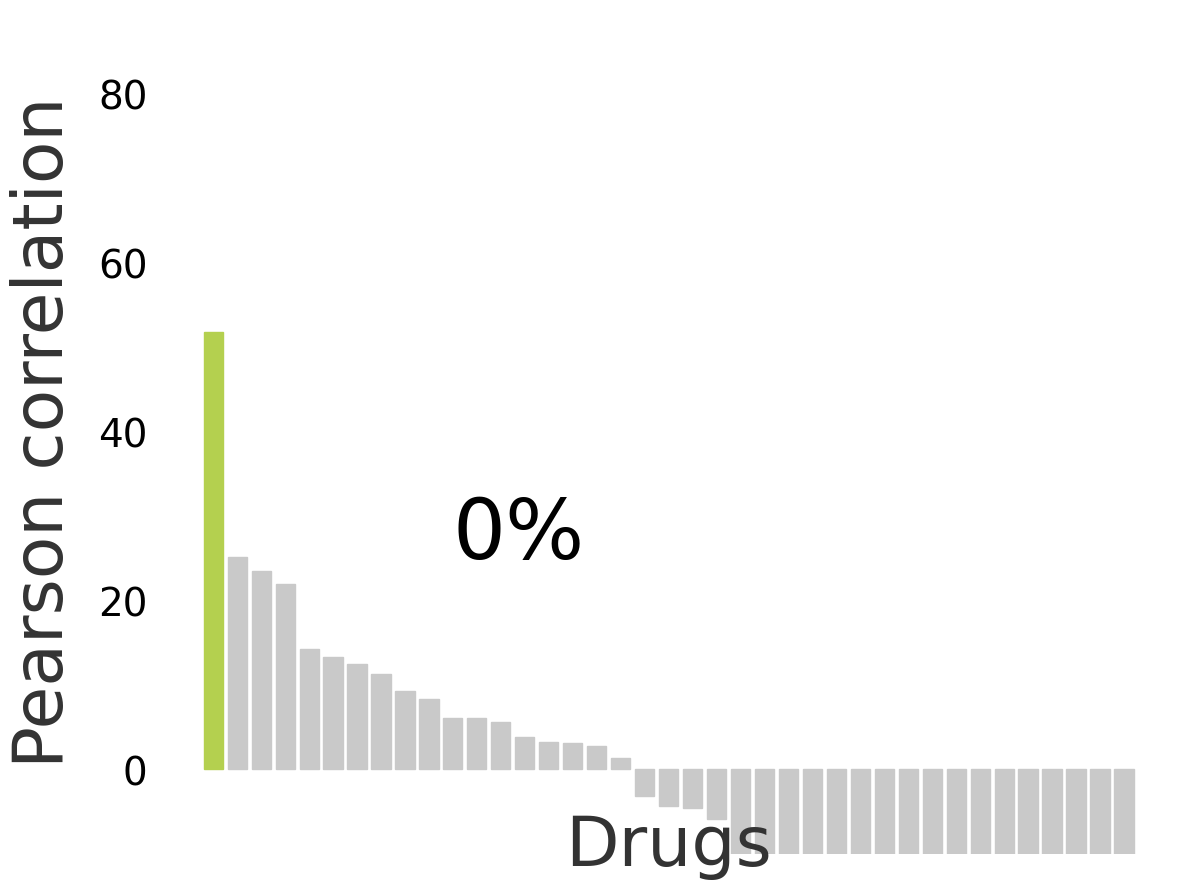

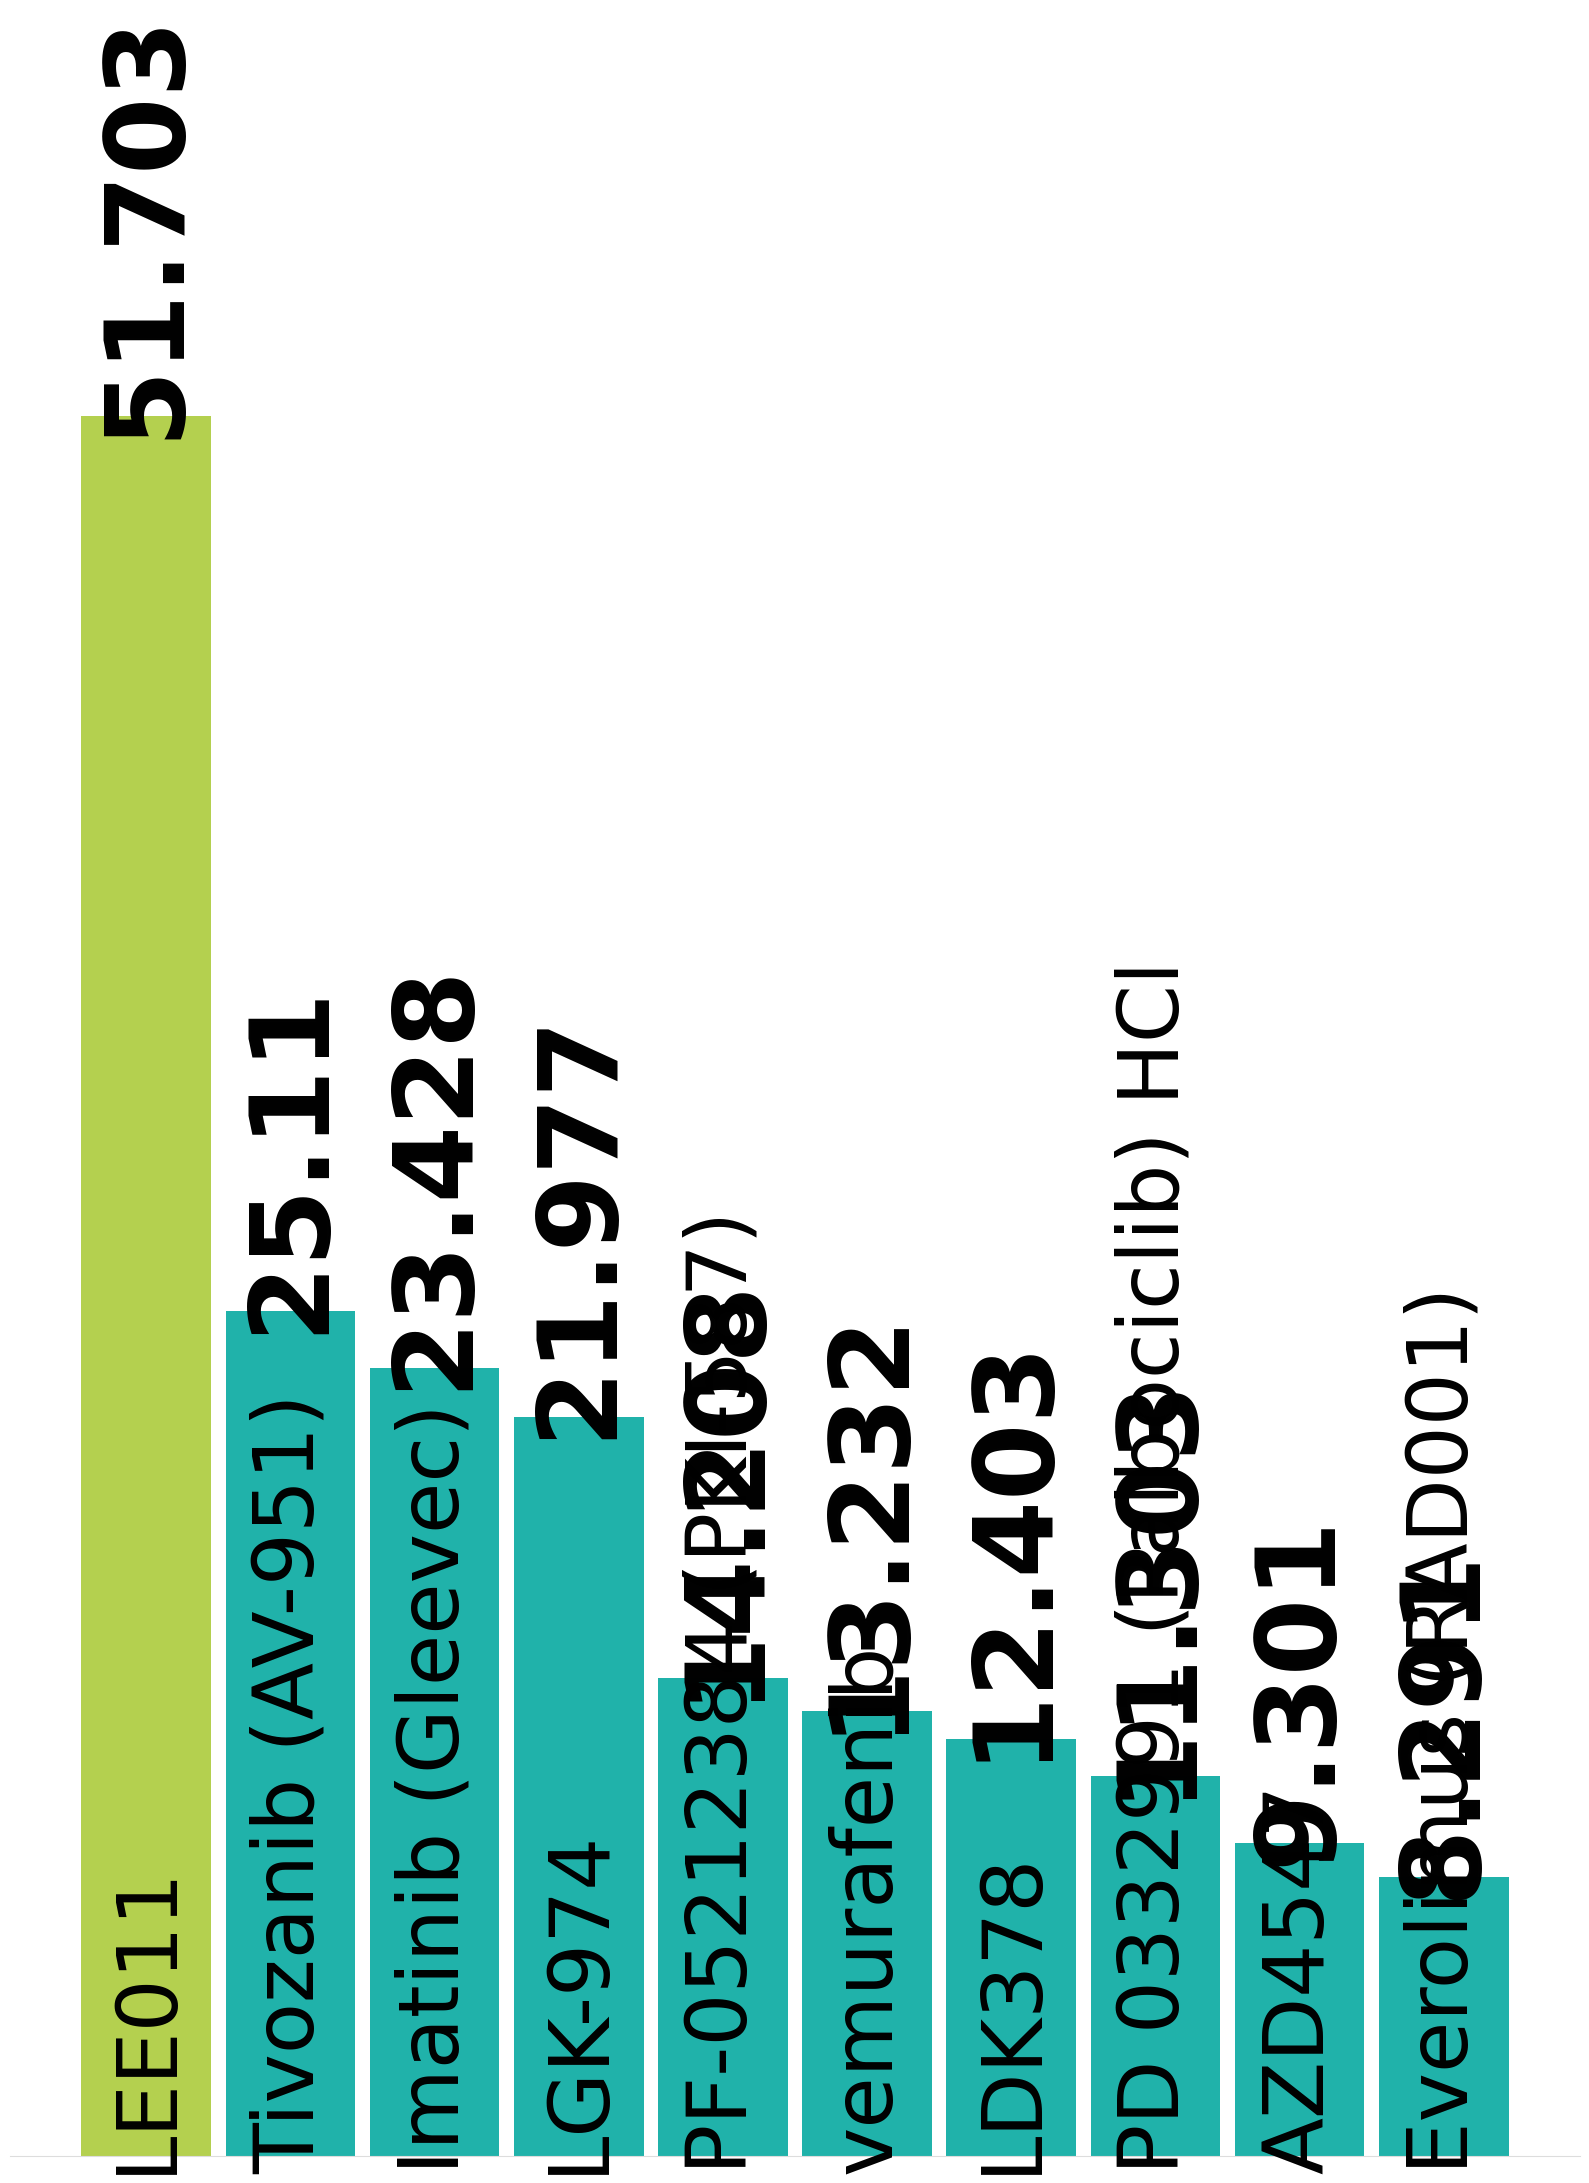

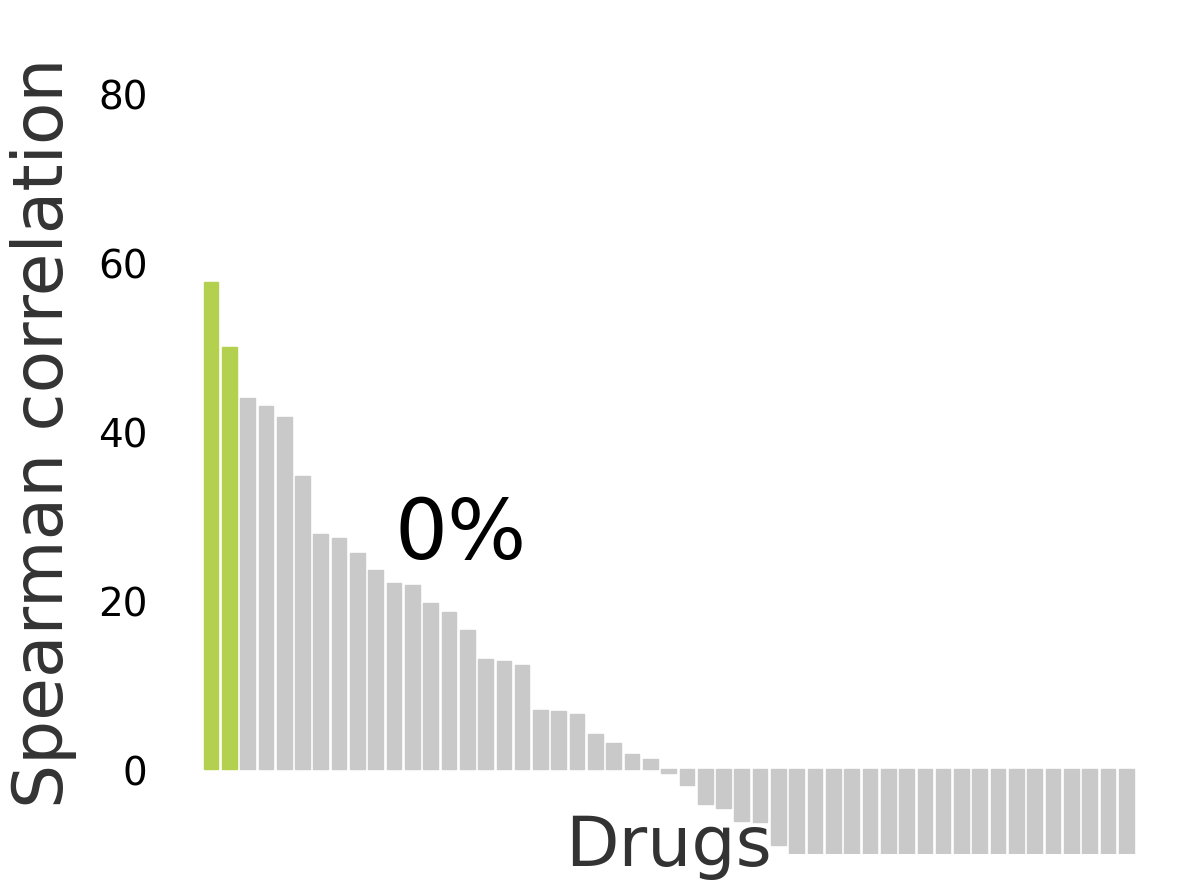

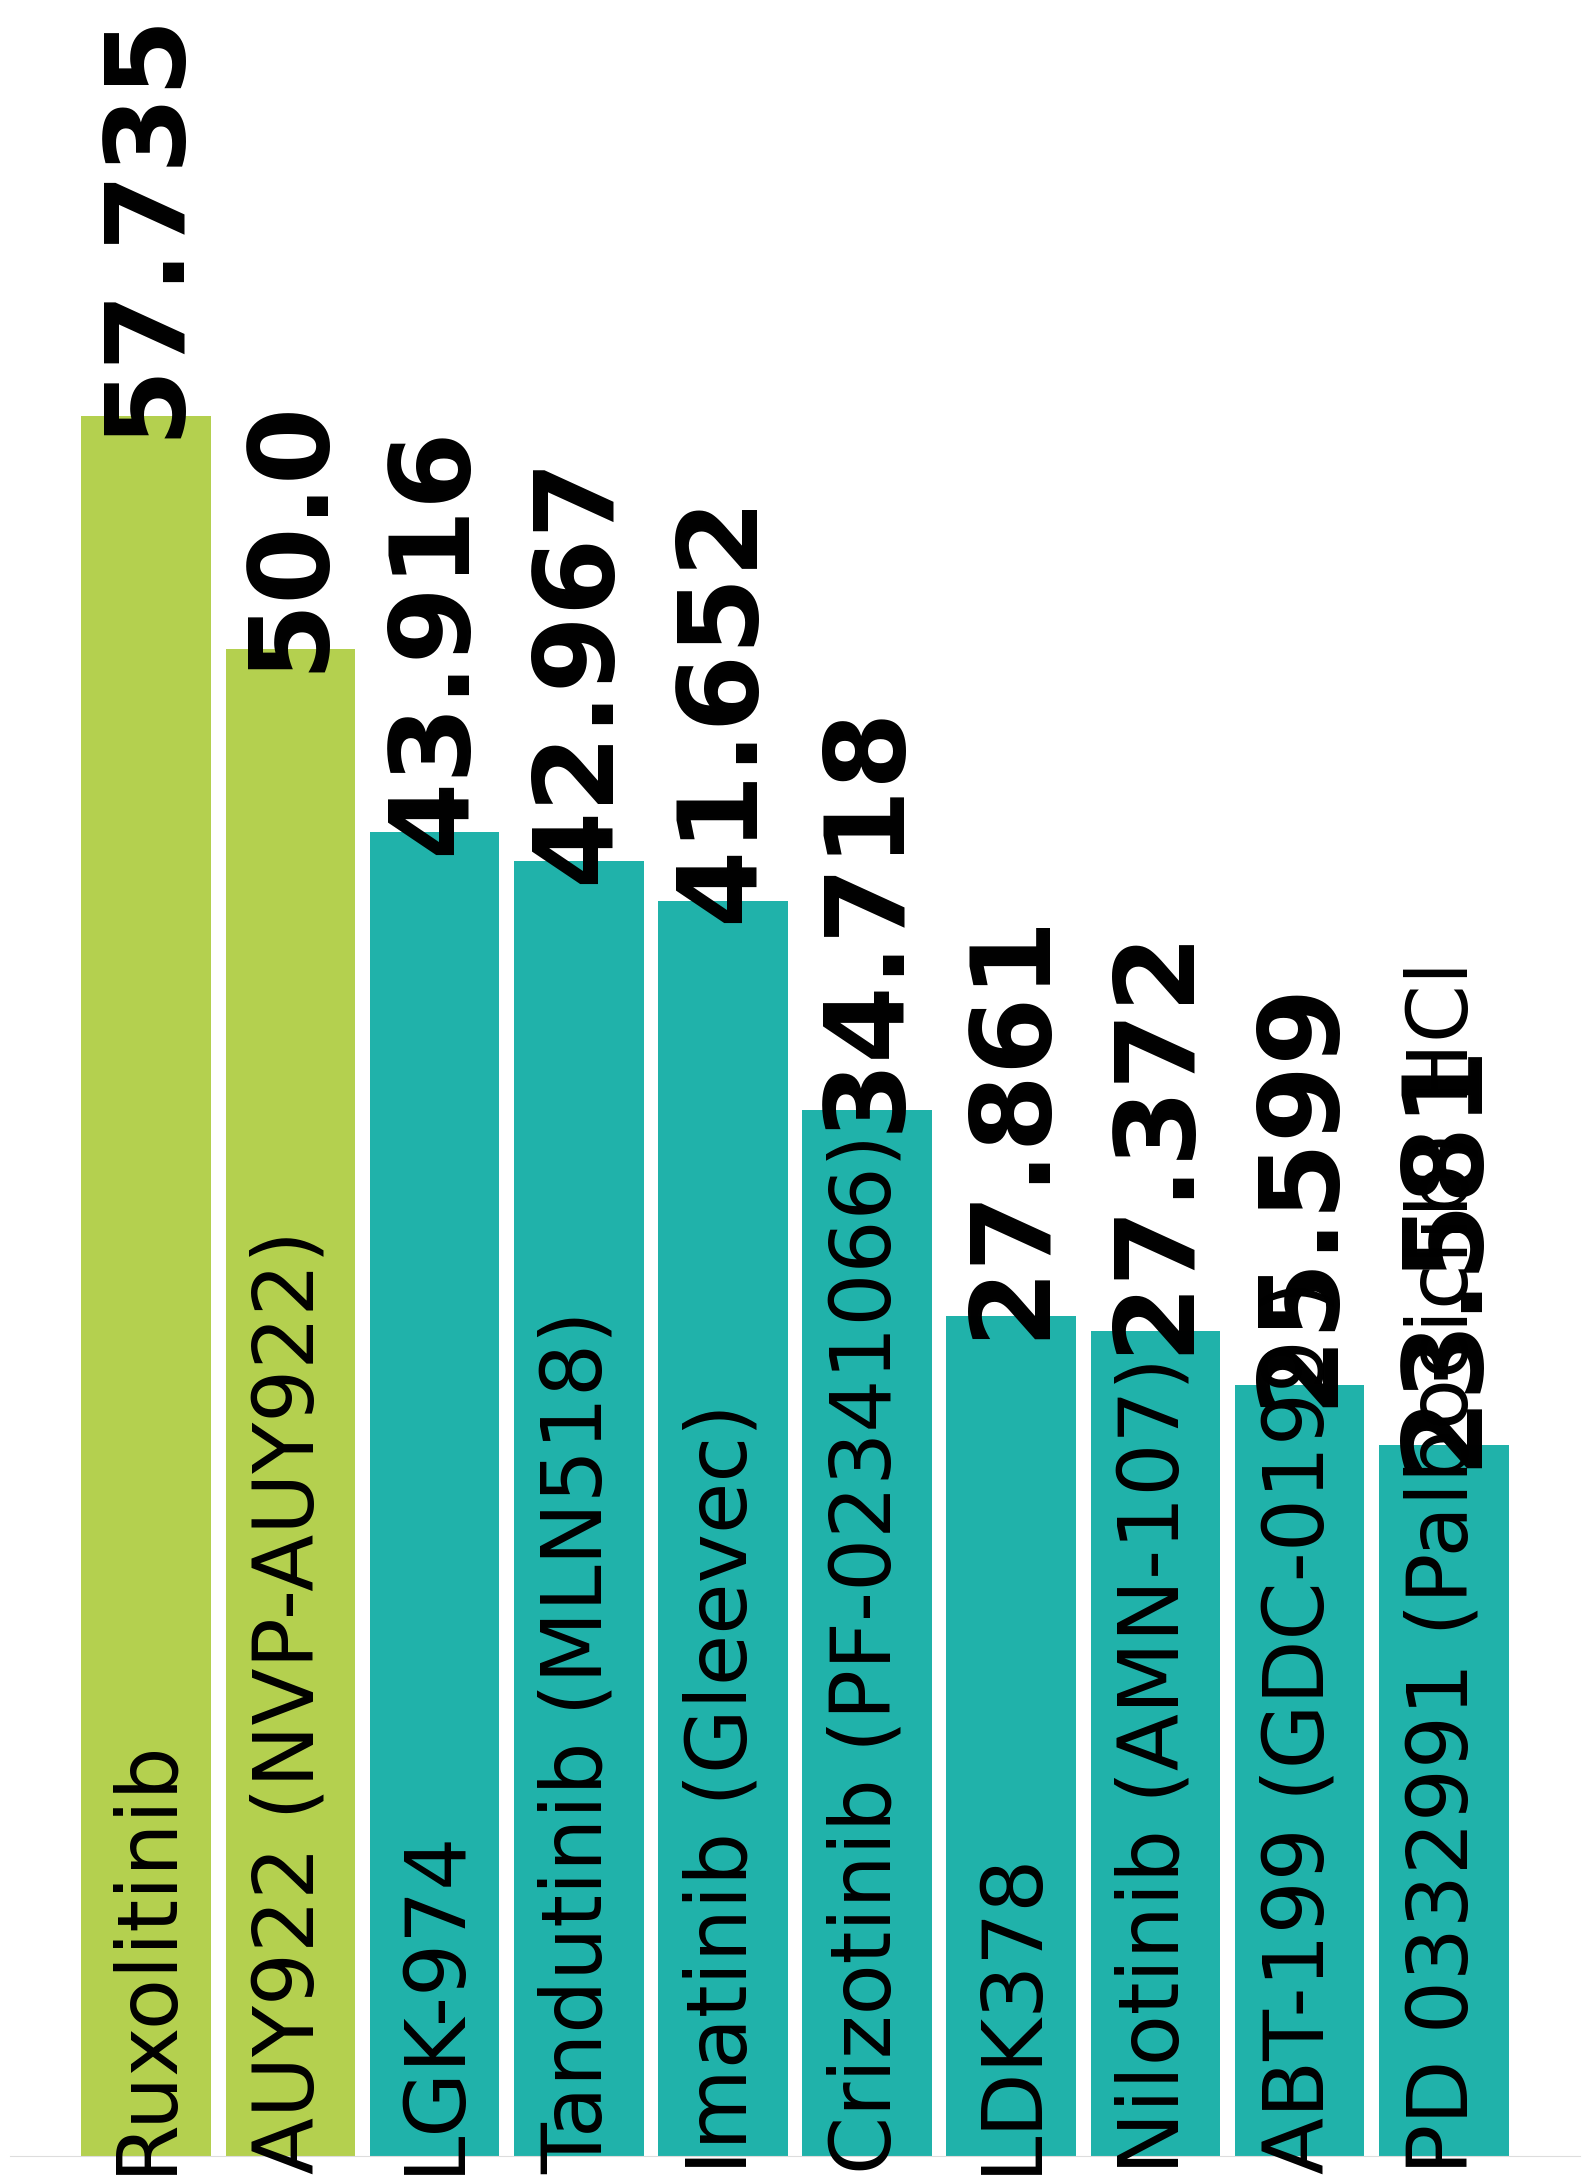

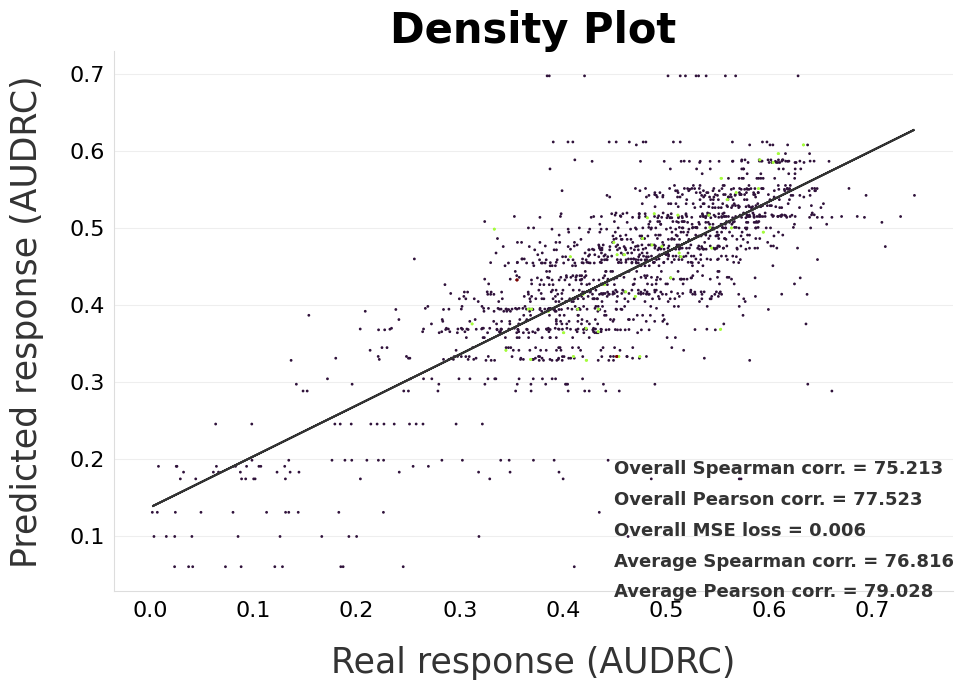

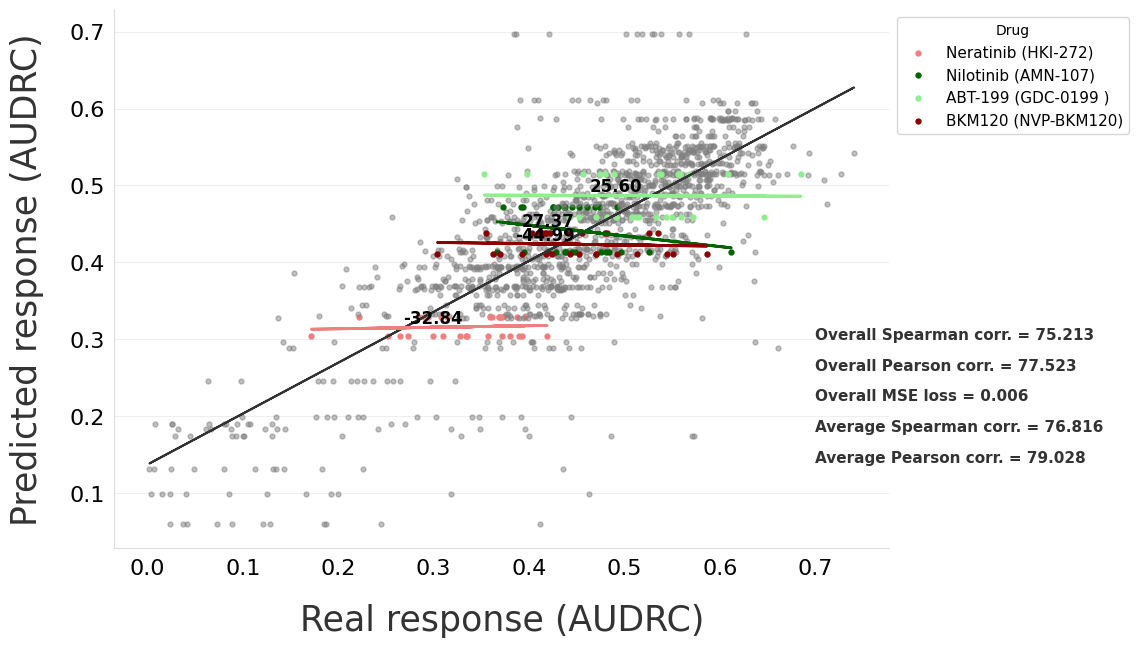

                                  Name       Mean
35                         Ruxolitinib  57.735027
29                 AUY922 (NVP-AUY922)  50.000000
46                             LGK-974  43.915503
38                 Tandutinib (MLN518)  42.966892
49                  Imatinib (Gleevec)  41.651698
24            Crizotinib (PF-02341066)  34.718254
54                              LDK378  27.861418
5                  Nilotinib (AMN-107)  27.372118
1                  ABT-199 (GDC-0199 )  25.599431
4         PD 0332991 (Palbociclib) HCl  23.580823
0                          PF-04449913  22.024471
23                         carfilzomib  21.835657
41                         vemurafenib  19.633200
56                            Axitinib  18.557687
12                             AZD5363  16.475129
44                              LEE011  13.101394
3                   Olaparib (AZD2281)  12.805560
50                 BGJ398 (NVP-BGJ398)  12.371791
48                             AZD4547   6.978632


Average pearson cor:,▁
Average pearson correlations of all drugs:,▁
Average spearman cor:,▁
Average spearman correlations of all drugs:,▁
Average pearson cor:,79.0276
Average pearson correlations of all drugs:,-7.12886
Average spearman cor:,76.8159
Average spearman correlations of all drugs:,0.86387


In [21]:
hyperparameters = {
    "input_type": input_type    # Adding input_type as a hyperparameter
    }

run = wandb.init(project=project, entity="miramon_team", name="final metrics drugs",tags=tags, job_type=job_type, config=hyperparameters)

input_folder = input_path_new
output_folder = output_path

druginput_name = drug2fingerprint_txt
drug2id = drug2id_txt
genomics_name = genotype_txt

cell2id = cell2id_txt
gene2id = gene2id_txt

labels_name =  "drugcell_test.txt"
predictions_name = "other_test_predictions.txt"

drugs_names = compounds_txt
model_name = "best_model_s.ckpt"

cuda = device

all_folds_metrics_and_plots(run,input_folder,output_folder,druginput_name,drug2id,genomics_name,cell2id,gene2id,labels_name,drugs_names,model_name,samples_folders,predictions_name,cuda,log_artifact=True)
run.finish()

# Interpretability

# TESTS!! ...

In [ ]:
test_loader = sparseGO_data.test_dataloader()
predictions = []
labels = []
input_data = []

with torch.inference_mode():
    for batch_idx, batch in enumerate(test_loader):
        result = model.test_step(batch, batch_idx)
        predictions.append(result["predictions"])
        labels.append(result["labels"])
        input_data.append(result["input_data"])
    
# Concatenate all batches into single tensors
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)
drugs_ids = input_data[0][:,1]
print(labels)